# LEARNING OF SEMANTICALLY EQUIVALENT QUESTIONS

In [1]:
# importing libraries
import keras
import nltk
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# import dataset from drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## IMPORTING DATASET FROM KAGGLE (optional)

The dataset can be downloaded from this website: https://www.kaggle.com/c/quora-question-pairs/data 

The below cells shows how the dataset can be extracted to the notebook from kaggle. 
To import the dataset from kaggle,
Go to your kaggle profile, Download kaggle.json from Kaggle -- MyAccount -- Create New API Token - auto downloads as "kaggle.json


In [3]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json to the notebook

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hshreedhar","key":"e96183fe90a76e704596438aec7c338b"}'}

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Kaggle/kaggle-questionpair/input')

In [6]:
!kaggle competitions download -c quora-question-pairs --force

 20% 1.00M/4.95M [00:00<00:01, 2.20MB/s]
100% 4.95M/4.95M [00:00<00:00, 10.1MB/s]
 80% 17.0M/21.2M [00:01<00:04, 1.05MB/s]
100% 21.2M/21.2M [00:01<00:00, 14.2MB/s]
 93% 105M/112M [00:08<00:00, 10.1MB/s] 
100% 112M/112M [00:08<00:00, 13.7MB/s]


# PREPARING THE DATASET

In [7]:
# Below is a sample dataset
# Dataset for training and validation
df = pd.read_csv('../input/train.csv') # read the CSV file 
df.head() # to vieww the first 5 contents in a file

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are setting the size of the training dataset in the block below. NUM_OF_SAMPLES can be changed as desired. 

NUM_OF_SAMPLES is the number of data points from each class. The total number of datapoints is 2*NUM_OF_SAMPLES

In [9]:
# to get equal number of duplicate and non duplicate question pairs in the dataset
NUM_OF_SAMPLES = 10000 # Using smaller sample for training set, for each subset.  

df_dup = df[df['is_duplicate'] == 1]
df_dup = df_dup[0:NUM_OF_SAMPLES]

df_diff = df[df['is_duplicate'] == 0]
df_diff = df_diff[0:NUM_OF_SAMPLES]

len(df_dup)

10000

### Limiting the size of the data set for an unbiased training

in the dataset, 60%  of the question-pairs do not have a duplicate pair and 40%  have a duplicate pair.
We are creating a subset of the database with equal number of qustion-pair with and without duplicates for an unbiased training. Off this sub-dataset that is created, we'll use 80% for taining and 20% for validation.

In [0]:
# here, we are spitting the dataset in training and validation, with 80% of the question-pair to training set and 20% for validation

num_of_train = int(round(0.8*NUM_OF_SAMPLES))       # Number of samples for training
num_of_valid = int(NUM_OF_SAMPLES - num_of_train)   # Number of samples for validation

In [0]:
# Choosing NUM_OF_SAMPLES random question pair for both duplicate and non-duplicate labels
dup_indices = np.random.choice(df_dup.index,size=num_of_train)
df_dup_train = df_dup.loc[dup_indices]

rem_indices = set(df_dup.index).difference(set(dup_indices)) # Remaining indices 
dup_valid_indices = np.random.choice(list(rem_indices),num_of_valid)
df_dup_valid = df_dup.loc[dup_valid_indices]

diff_indices = np.random.choice(df_diff.index,size=num_of_train)
df_diff_train = df_diff.loc[diff_indices]

rem_indices = set(df_diff.index).difference(set(diff_indices)) # Remaining indices 
diff_valid_indices = np.random.choice(list(rem_indices),num_of_valid)
df_diff_valid = df_diff.loc[diff_valid_indices]


In [0]:
# Selecting Training and Validation data points
df_train = pd.concat([df_dup_train,df_diff_train])
df_valid = pd.concat([df_dup_valid, df_diff_valid])

df_train_label = df_dup_train['is_duplicate']
df_train_label = df_train_label.append(df_diff_train['is_duplicate'])

df_valid_label = df_dup_valid['is_duplicate']
df_valid_label = df_valid_label.append(df_diff_valid['is_duplicate'])

df_train = df_train[['question1','question2']]
df_valid = df_valid[['question1', 'question2']]

Here, we have our dataset ready for training "df_train" and "df_valid" for validation. Duplicate values are the lables

In [13]:
# this block is to fetch the total number of duplicate questomn pair in the training set
print('Total number of question pain in the training set: {}'.format(len(df_train)))

Total number of question pain in the training set: 16000


In [14]:
print(df_train.shape)
print(df_valid.shape)

(16000, 2)
(4000, 2)


### Pre-processing the questions

In [0]:
# cleaning up of the dataset 
import re
import string

re_punc = re.compile('[%s]' % re.escape(string.punctuation))
re_print = re.compile('[^%s]' % re.escape(string.printable))

def pre_process_line (line):
  # tokenize on white space
  try:
    line = line.split()
    # convert to lowercase
    line = [word.lower() for word in line]
    # remove punctuation from each token
    line = [re_punc.sub('', w) for w in line]
    # remove non-printable chars form each token
    line = [re_print.sub('', w) for w in line]
    # remove tokens with numbers in them
    line = [word for word in line if word.isalpha()]
    return ' '.join(line)
  except:
    return ' '

def pre_process_questions(ques):
  df_processed = ques.copy(deep=True)
  for i in range(ques.shape[0]):
    line = pre_process_line(ques.iloc[i])
    df_processed.iloc[i] = line  
  return df_processed

In [0]:
df_train_q1 = df_train['question1'].apply(pre_process_line)
df_train_q2 = df_train['question2'].apply(pre_process_line)
df_valid_q1 = df_valid['question1'].apply(pre_process_line)
df_valid_q2 = df_valid['question2'].apply(pre_process_line)


### Encoding the questions

The word embedding (from q1 and q2) are split to training and validation datasets. Further, the words within the questions are encoded using one-hot-encoding

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


all_qs = df_train_q1.tolist() + df_train_q2.tolist() + df_valid_q1.tolist() + df_valid_q2.tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_qs)
vocab_size = len(tokenizer.word_index) + 1
encoded_qs = tokenizer.texts_to_sequences(all_qs)

MAX_QUES_LEN = 300
padded_qs = pad_sequences(encoded_qs,maxlen=MAX_QUES_LEN,padding='post')

In [0]:
# Divide the questions

encoded_train_q1 = padded_qs[0:(2*num_of_train)]
encoded_train_q2 = padded_qs[(2*num_of_train):(4*num_of_train)]
encoded_valid_q1 = padded_qs[(4*num_of_train):(4*num_of_train+2*num_of_valid)]
encoded_valid_q2 = padded_qs[(4*num_of_train+2*num_of_valid):]


In [20]:
encoded_valid_q1.shape

(4000, 300)

### Initializing Embedding layer using GloVe 

In [21]:
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/content/gdrive/My Drive/NLP- Deep Learning/glove.6B.300d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.300d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
WORD2VEC = KeyedVectors.load_word2vec_format(word2vec_glove_file)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
EMBEDDING_DIM = 300 # embedding dimentions are set to 300 as we are training on a 300 dimention word vector

def embeddings_init(shape,dtype=None):
    embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
    not_present = []
    for word, idx in tokenizer.word_index.items():
      try:
        vec = WORD2VEC[word]
        if vec is not None:
          embedding_matrix[idx] = vec
      except:
        not_present.append(word)
        continue
    print(len(not_present))
    return embedding_matrix
  

# TRAIN THE MODEL

In [0]:
import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Embedding
from keras import models
from keras.optimizers import SGD

In [0]:
def get_siamese_model(input_shape):
  """
    Model architecture
  """
    
  q1_input = Input(input_shape)
  q2_input = Input(input_shape)

  model = models.Sequential()

  model.add(Embedding(vocab_size,EMBEDDING_DIM,input_length=MAX_QUES_LEN,
                      embeddings_initializer=embeddings_init))

  # 1st is a conv layer with max-pooling with 300 neurons with kernel size as 15
  model.add(Conv1D(300, 15,activation='tanh')) # Conv1D
  model.add(MaxPooling1D(pool_size=2))
           
  # next will ne deep network of 3 fully-connected layer with 50 neuron each

  model.add(Dense(50, activation='tanh'))
  model.add(Dense(50, activation='tanh'))
  model.add(Dense(50, activation ='tanh'))
  
  # Generate the encodings (feature vectors) for the two images
  model_q1 = model(q1_input)
  model_q2 = model(q2_input)
  
  # concatenating the outputs from the 2 model-layers of the siamese network 
  concat = keras.layers.Concatenate()([model_q1, model_q2])
  flatcat = Flatten()(concat)
  
  # Add a dense layer with sigmoid to generate the similarity score
  prediction = Dense(1,activation='tanh')(flatcat)

  # Connect the inputs with the outputs
  siamese_net = models.Model(inputs=[q1_input, q2_input],outputs=prediction)

  return siamese_net,model

In [25]:
# creating the network
siamese_net, seqmodel = get_siamese_model((MAX_QUES_LEN,))
siamese_net.summary()
seqmodel.summary()

W0805 03:39:46.018667 140377308571520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 03:39:46.067380 140377308571520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 03:39:46.261919 140377308571520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 03:39:46.294217 140377308571520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



2119
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 143, 50)      6479450     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 143, 100)     0           sequential_1[1][0]               
     

# FIT THE DATA

In [26]:
# Define optimiser, learning rate
optimizer = SGD(lr = 0.01) 
siamese_net.compile(loss="mean_squared_error",optimizer=optimizer,metrics=['accuracy'])
history = siamese_net.fit([encoded_train_q1,encoded_train_q2], df_train_label, validation_data=([encoded_valid_q1,encoded_valid_q2],df_valid_label),epochs=20, verbose=2, batch_size=64)

W0805 03:39:50.902232 140377308571520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 03:39:51.193379 140377308571520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0805 03:39:51.259613 140377308571520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 22s - loss: 0.2373 - acc: 0.5990 - val_loss: 0.2351 - val_acc: 0.5992
Epoch 2/20
 - 15s - loss: 0.2222 - acc: 0.6422 - val_loss: 0.2305 - val_acc: 0.6170
Epoch 3/20
 - 15s - loss: 0.2113 - acc: 0.6691 - val_loss: 0.2293 - val_acc: 0.6138
Epoch 4/20
 - 16s - loss: 0.1998 - acc: 0.6974 - val_loss: 0.2265 - val_acc: 0.6338
Epoch 5/20
 - 16s - loss: 0.1871 - acc: 0.7258 - val_loss: 0.2260 - val_acc: 0.6392
Epoch 6/20
 - 16s - loss: 0.1748 - acc: 0.7508 - val_loss: 0.2304 - val_acc: 0.6395
Epoch 7/20
 - 16s - loss: 0.1601 - acc: 0.7794 - val_loss: 0.2323 - val_acc: 0.6415
Epoch 8/20
 - 16s - loss: 0.1432 - acc: 0.8158 - val_loss: 0.2405 - val_acc: 0.6325
Epoch 9/20
 - 16s - loss: 0.1276 - acc: 0.8435 - val_loss: 0.2480 - val_acc: 0.6272
Epoch 10/20
 - 16s - loss: 0.1109 - acc: 0.8740 - val_loss: 0.2521 - val_acc: 0.6225
Epoch 11/20
 - 16s - loss: 0.0949 - acc: 0.8994 - val_loss: 0.2644 - val_acc: 0.6175
Epoch 12/20
 - 16s - loss

In [27]:
print('Number of training samples = {}'.format(num_of_train))
print('Number of validation samples = {}'.format(num_of_valid))
print('Vocabulary size = {}'.format(vocab_size))

Number of training samples = 8000
Number of validation samples = 2000
Vocabulary size = 17030


# PLOT GRAPHS

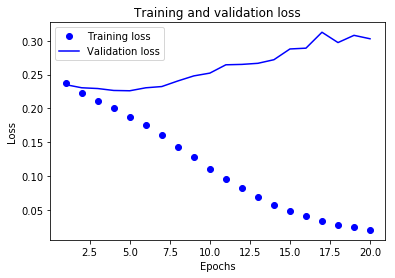

In [28]:
# Plotting training and validation loss (from lecture 2 notes)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

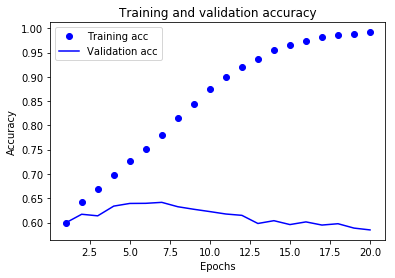

In [29]:
# Plotting training and validation accuracy (from lecture 2 notes)
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()